In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import shutil
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/tmp/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset_path= '/tmp/chest_xray/'
new_dataset_path = '/tmp/chest_xray_new/'
if not os.path.exists(new_dataset_path):
   for split in ['train', 'val', 'test']:
       for cls in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

   for cls in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for split in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{split}/{cls}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)

       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{new_dataset_path}/train/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{new_dataset_path}/val/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{new_dataset_path}/test/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest) 

/tmp/chest_xray/chest_xray\.DS_Store
/tmp/chest_xray/chest_xray\test\.DS_Store
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0001-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0003-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0005-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0006-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0007-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0009-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0010-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001-0002.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0013-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0015-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0016-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0017-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0019-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0021-0001.jpeg

In [2]:
input_shape = (224, 224, 3)

train_path =  '/tmp/chest_xray_new/train'
test_path =  '/tmp/chest_xray_new/test'
valid_path =  '/tmp/chest_xray_new/val'


In [5]:
inceptionV3=InceptionV3(input_shape = input_shape, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet' )

In [6]:

# don't train existing weights
for layer in inceptionV3.layers:
    layer.trainable = False

In [7]:
# our layers - 
x = Flatten()(inceptionV3.output)

In [8]:
prediction = Dense(2, activation='softmax')(x)

In [9]:
model = Model(inputs=inceptionV3.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4684 images belonging to 2 classes.


In [14]:
valid_set = valid_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 587 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 585 images belonging to 2 classes.


In [16]:
import math
import numpy as np
batch_size=32

number_of_examples = len(test_set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / batch_size)

test_labels = []

# Iterate through the generator calls
for i in range(0, int(number_of_generator_calls)):
    # Get the labels for the current batch
    batch_labels = np.array(test_set[i][1])
    test_labels.extend(batch_labels)
    


In [17]:
# fit the model

r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=10,
 
)


Epoch 1/10
147/147 [==============================] - 122s 776ms/step - loss: 1.9351 - accuracy: 0.8614 - val_loss: 1.3090 - val_accuracy: 0.8518
Epoch 2/10
147/147 [==============================] - 109s 741ms/step - loss: 0.5633 - accuracy: 0.9182 - val_loss: 0.5433 - val_accuracy: 0.9182
Epoch 3/10
103/147 [====================>.........] - ETA: 29s - loss: 0.6398 - accuracy: 0.9226

KeyboardInterrupt: 

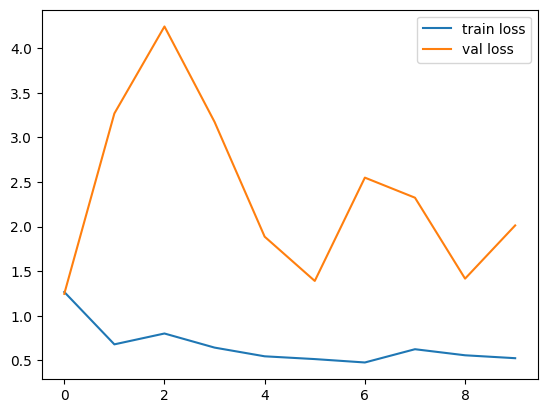

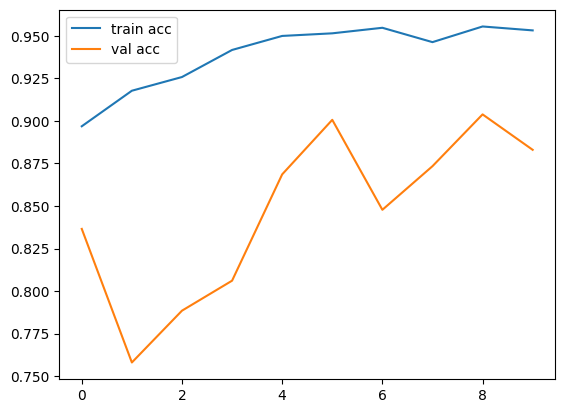

<Figure size 640x480 with 0 Axes>

In [109]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')

plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [110]:
test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - accuracy: 0.8125 - loss: 4.1113
Test accuracy: 0.8125


In [114]:
from sklearn.metrics import classification_report


y_pred = model.predict(test_set)

print(classification_report(np.argmax(test_labels,axis=1), np.argmax(y_pred,axis=1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [ ]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')

In [ ]:
def show_image(img_name):
  img = plt.imread(img_name)
  plt.imshow(img)
  plt.show()